In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from scipy.stats import loguniform as log_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

In [ ]:
df = pd.read_csv("cosmic_clinvar.tsv", sep="\t")

<ipython-input-2-0d300dfc8c8a>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cosmic_clinvar.tsv", sep="\t")


In [ ]:
df = df[df["MUTATION_AA"] != "p.?"]
df = df[df["Pathogenicity"] != "Uncertain"]
df["Label"] = df["Pathogenicity"].map({"Pathogenic": 1, "Benign": 0})

<ipython-input-3-1a4e373497bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Label"] = df["Pathogenicity"].map({"Pathogenic": 1, "Benign": 0})


In [ ]:
df.shape

(650543, 19)

In [ ]:
df.dtypes

,0
GENE_SYMBOL,object
MUTATION_CDS,object
MUTATION_AA,object
MUTATION_DESCRIPTION,object
MUTATION_ZYGOSITY,object
MUTATION_SOMATIC_STATUS,object
CHROMOSOME,object
GENOME_START,int64
GENOME_STOP,int64
GENOMIC_WT_ALLELE,object


In [ ]:
df.head()

,GENE_SYMBOL,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,MUTATION_SOMATIC_STATUS,CHROMOSOME,GENOME_START,GENOME_STOP,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,LOH,PUBMED_PMID,STRAND,Pathogenicity,BLOSUM62_Score,Hydrophobicity_Change,Charge_Change,Label
11,LZTR1,c.210G>A,p.K70=,synonymous_variant,NaN,Reported in another cancer sample as somatic,22,21337325,21337325,G,A,NaN,31470906.0,+,Benign,0.0,0.0,0.0,0
14,LZTR1,c.1683C>T,p.R561=,synonymous_variant,NaN,Reported in another cancer sample as somatic,22,21348914,21348914,C,T,NaN,31470906.0,+,Benign,0.0,0.0,0.0,0
15,LZTR1,c.1683C>T,p.R561=,synonymous_variant,NaN,Reported in another cancer sample as somatic,22,21348914,21348914,C,T,NaN,31470906.0,+,Benign,0.0,0.0,0.0,0
18,LZTR1,c.2191G>A,p.E731K,missense_variant,NaN,Confirmed somatic variant,22,21350373,21350373,G,A,NaN,33016334.0,+,Pathogenic,1.0,-0.4,2.0,1
19,LZTR1,c.743G>A,p.G248E,missense_variant,NaN,Reported in another cancer sample as somatic,22,21344766,21344766,G,A,NaN,36219477.0,+,Pathogenic,-2.0,-3.1,-1.0,1


In [ ]:
df.isna().mean()*100

,0
GENE_SYMBOL,0.000000
MUTATION_CDS,0.000000
MUTATION_AA,0.000000
MUTATION_DESCRIPTION,0.000000
MUTATION_ZYGOSITY,85.997390
MUTATION_SOMATIC_STATUS,0.000000
CHROMOSOME,0.000000
GENOME_START,0.000000
GENOME_STOP,0.000000
GENOMIC_WT_ALLELE,0.581822


In [ ]:
def extract_aa_length_change(mutation_aa):
    """Extracts amino acid length change from MUTATION_AA column."""
    if not isinstance(mutation_aa, str) or len(mutation_aa) < 3:
        return 0  # Default value for missing or invalid data

    aa_change = mutation_aa[2:]  # Remove 'p.' prefix

    # Handle insertions (e.g., "p.K1107_T1108insFFNDTA")
    if "ins" in aa_change:
        inserted_part = aa_change.split("ins")[-1]  # Extract inserted sequence
        return len(inserted_part)  # Length of inserted amino acids

    # Handle deletions (e.g., "p.K1107_T1108del")
    if "del" in aa_change:
        deleted_part = aa_change.split("del")[-1]
        return -len(deleted_part)  # Negative length for deletions

    # Handle standard substitutions (e.g., "p.K70R")
    if len(aa_change) > 3 and aa_change[-1] != "=":
        return 1  # Most substitutions change 1 AA at a time

    return 0  # No length change for synonymous mutations

# Apply function to extract only AA_Length_Change
df["AA_Length_Change"] = df["MUTATION_AA"].apply(extract_aa_length_change)

In [ ]:
def extract_cds_features(mutation_cds):
    """Extracts key mutation features from MUTATION_CDS."""
    if pd.isna(mutation_cds):
        return pd.Series([0, 0, 0, 0])  # Default values

    is_substitution = 1 if ">" in mutation_cds else 0
    is_insertion = 1 if "ins" in mutation_cds else 0
    is_deletion = 1 if "del" in mutation_cds else 0
    is_duplication = 1 if "dup" in mutation_cds else 0

    return pd.Series([is_substitution, is_insertion, is_deletion, is_duplication])

# Apply function and create new columns
df[["CDS_Substitution", "CDS_Insertion", "CDS_Deletion", "CDS_Duplication"]] = df["MUTATION_CDS"].apply(extract_cds_features)


In [ ]:
def encode_genomic_change(wt_allele, mut_allele):
    """Encodes nucleotide changes into meaningful numerical values."""
    if pd.isna(wt_allele) and pd.isna(mut_allele):
        return pd.Series([0, 0])  # No meaningful data

    # Length of change (positive for insertions, negative for deletions)
    wt_length = len(str(wt_allele)) if pd.notna(wt_allele) else 0
    mut_length = len(str(mut_allele)) if pd.notna(mut_allele) else 0
    length_change = mut_length - wt_length

    # Count of nucleotide changes
    if wt_length == mut_length and wt_length == 1:  # Single base substitution
        nucleotide_change = 1
    else:
        nucleotide_change = abs(length_change)  # Count of nucleotides inserted or deleted

    return pd.Series([length_change, nucleotide_change])

# Apply the function
df[["Genomic_Length_Change", "Genomic_Nucleotide_Change"]] = df.apply(
    lambda row: encode_genomic_change(row["GENOMIC_WT_ALLELE"], row["GENOMIC_MUT_ALLELE"]), axis=1
)

In [ ]:
mutation_types = df["MUTATION_DESCRIPTION"].dropna().unique()

unique_categories = set()
for desc in mutation_types:
    unique_categories.update(desc.split(","))

def one_hot_encode_mutation_description(df, column="MUTATION_DESCRIPTION"):
    """One-hot encode mutation descriptions by handling multi-category values."""
    # Extract unique categories dynamically
    unique_categories = set()
    df[column].dropna().apply(lambda x: unique_categories.update(x.split(",")))  # Handle NaNs

    # Create binary columns for each category
    for category in unique_categories:
        df[category] = df[column].str.contains(category, na=False).astype(int)

    return df

df = one_hot_encode_mutation_description(df)

In [ ]:
df["BLOSUM62_Score"].fillna(0, inplace=True)
df["Hydrophobicity_Change"].fillna(0, inplace=True)
df["Charge_Change"].fillna(0, inplace=True)
df[["Genomic_Length_Change", "Genomic_Nucleotide_Change"]].fillna(0, inplace=True)

<ipython-input-12-9c37aa7f04df>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["BLOSUM62_Score"].fillna(0, inplace=True)
<ipython-input-12-9c37aa7f04df>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [ ]:
# Encode
label_encoder = LabelEncoder()
df["Gene_Encoded"] = label_encoder.fit_transform(df["GENE_SYMBOL"])

df = pd.get_dummies(df, columns=["MUTATION_SOMATIC_STATUS"], drop_first=True)

# Convert to numeric
bool_cols = df.select_dtypes(include=['bool']).columns  # Identify boolean columns
df[bool_cols] = df[bool_cols].astype(int)
df['CHROMOSOME'] = df['CHROMOSOME'].replace({'X': '23'})
df['CHROMOSOME'] = pd.to_numeric(df['CHROMOSOME'], errors='coerce')

df['STRAND'] = df['STRAND'].apply(lambda x: 1 if x == '+' else 0)

# Drop
df.drop(columns=["GENE_SYMBOL","MUTATION_AA", "MUTATION_CDS", "MUTATION_DESCRIPTION","PUBMED_PMID","LOH","MUTATION_ZYGOSITY","Pathogenicity","GENOMIC_WT_ALLELE","GENOMIC_MUT_ALLELE"],axis=1,inplace=True)


In [ ]:
df

,CHROMOSOME,GENOME_START,GENOME_STOP,STRAND,BLOSUM62_Score,Hydrophobicity_Change,Charge_Change,Label,AA_Length_Change,CDS_Substitution,...,5_prime_UTR_variant,splice_acceptor_variant,stop_gained,missense_variant,start_lost,inframe_insertion,Gene_Encoded,MUTATION_SOMATIC_STATUS_Not specified,MUTATION_SOMATIC_STATUS_Reported in another cancer sample as somatic,MUTATION_SOMATIC_STATUS_Variant of unknown origin
11,22,21337325,21337325,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,332,0,1,0
14,22,21348914,21348914,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,332,0,1,0
15,22,21348914,21348914,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,332,0,1,0
18,22,21350373,21350373,1,1.0,-0.4,2.0,1,1,1,...,0,0,0,1,0,0,332,0,0,0
19,22,21344766,21344766,1,-2.0,-3.1,-1.0,1,1,1,...,0,0,0,1,0,0,332,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959941,8,56922652,56922652,1,2.0,-1.9,1.0,1,1,1,...,0,0,0,1,0,0,331,0,0,0
959942,8,56866452,56866452,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,331,0,1,0
959946,8,56922615,56922615,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,331,0,0,1
959948,8,56879440,56879440,1,0.0,0.0,0.0,0,0,1,...,0,0,0,0,0,0,331,0,0,0


In [ ]:
df.isna().mean()*100

,0
CHROMOSOME,0.0
GENOME_START,0.0
GENOME_STOP,0.0
STRAND,0.0
BLOSUM62_Score,0.0
Hydrophobicity_Change,0.0
Charge_Change,0.0
Label,0.0
AA_Length_Change,0.0
CDS_Substitution,0.0


In [ ]:
df.dtypes

,0
CHROMOSOME,int64
GENOME_START,int64
GENOME_STOP,int64
STRAND,int64
BLOSUM62_Score,float64
Hydrophobicity_Change,float64
Charge_Change,float64
Label,int64
AA_Length_Change,int64
CDS_Substitution,int64


In [ ]:
df.shape

(650543, 33)

In [ ]:
df.to_csv("cosmic_clinvar_processed.tsv", sep="\t", index=False)

In [ ]:
X = df.drop(columns=['Label'])
Y = df['Label']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train - test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [ ]:
# Initialize PCA (or IncrementalPCA if the data is large)
pca = PCA(n_components=10)  # Adjust n_components as needed

# Fit PCA on the data
pca.fit(X_scaled)

# Print the explained variance ratio for each component
print("Explained variance ratio for each component:")
print(pca.explained_variance_ratio_)

# Print the cumulative explained variance
print("\nCumulative explained variance:")
print(pca.explained_variance_ratio_.cumsum())


Explained variance ratio for each component:
[0.1128009  0.09229306 0.07399767 0.06559144 0.05115718 0.04829971
 0.0440166  0.03783782 0.03751127 0.03157322]

Cumulative explained variance:
[0.1128009  0.20509395 0.27909163 0.34468306 0.39584024 0.44413995
 0.48815655 0.52599437 0.56350563 0.59507885]


Canonical Correlation Coefficient: 0.6980


<ipython-input-21-9ceb7ef5ea36>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Loading', y='Feature', data=loadings, palette="viridis")


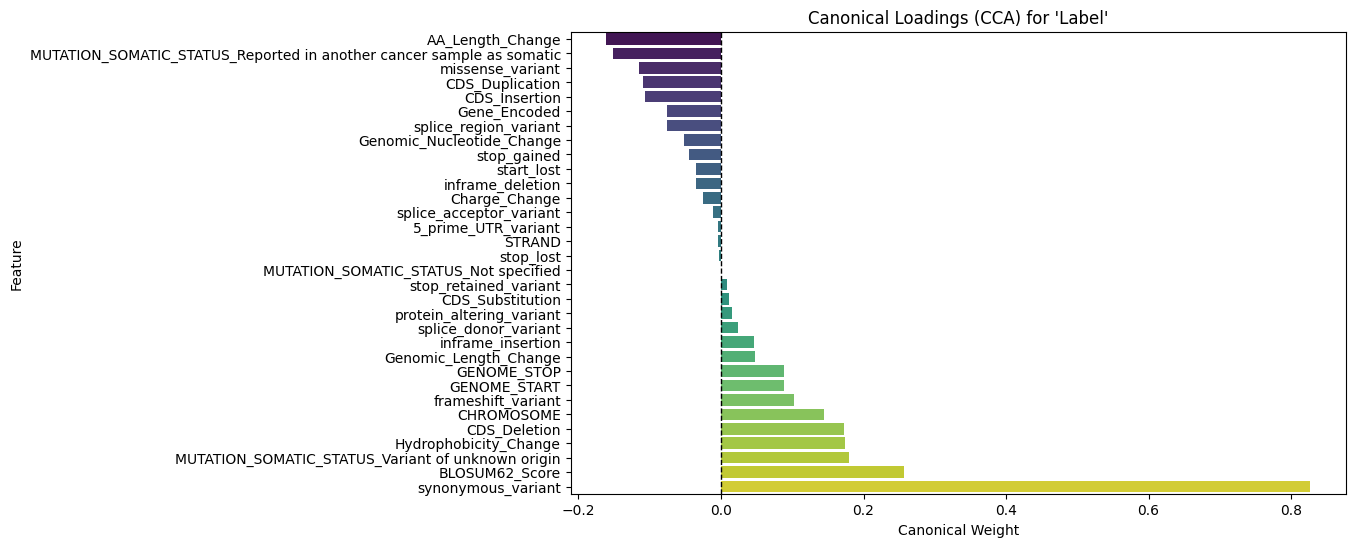

In [ ]:
# Initialize and fit CCA
cca = CCA(n_components=1)  # Using 1 component for simplicity
X_c, Y_c = cca.fit_transform(X_scaled, Y)

# Compute canonical correlation coefficient
correlation = np.corrcoef(X_c.T, Y_c.T)[0, 1]
print(f"Canonical Correlation Coefficient: {correlation:.4f}")

# Store feature loadings in a DataFrame
loadings = pd.DataFrame({
    'Feature': X.columns,
    'Loading': cca.x_weights_.flatten()
}).sort_values(by='Loading', ascending=True)

# Plot the feature loadings
plt.figure(figsize=(10, 6))
sns.barplot(x='Loading', y='Feature', data=loadings, palette="viridis")

plt.xlabel("Canonical Weight")
plt.ylabel("Feature")
plt.title("Canonical Loadings (CCA) for 'Label'")
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Reference line at 0
plt.show()



In [ ]:
# Define 5-fold cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define hyperparameter search space
param_dist = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [None, 5, 10, 20, 30],  # Tree depth
    "min_samples_split": [2, 5, 10, 20],  # Minimum samples per split
    "min_samples_leaf": [1, 2, 4, 8],  # Minimum samples per leaf
    "max_features": ["sqrt", "log2", None],  # Number of features per split
    "bootstrap": [True, False],  # Use bootstrap sampling
    "class_weight": ["balanced", None]  # Handle class imbalance
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=10,  # Number of different random combinations to try
    scoring="f1",  # Optimize for F1-score
    cv=cv, n_jobs=-1, verbose=1, random_state=42
)

# Train model with hyperparameter tuning on training + validation set
random_search.fit(X_train, Y_train)

best_rf = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
Y_pred_test = best_rf.predict(X_test)
Y_pred_prob = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Accuracy
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# F1-Score
test_f1 = f1_score(Y_test, Y_pred_test)
print(f"Test F1-Score: {test_f1:.4f}")

# ROC-AUC
test_roc_auc = roc_auc_score(Y_test, Y_pred_prob)
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.9666
Test F1-Score: 0.9804
Test ROC-AUC: 0.9933


In [ ]:
# Store feature names before scaling
feature_names = df.drop(columns=['Label']).columns

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Get feature importances
feature_importances = best_rf.feature_importances_

# Create a DataFrame to rank features
feature_importance_df = pd.DataFrame({
    "Feature": X_train_df.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print(feature_importance_df.head(10))

                                              Feature  Importance
20                                 synonymous_variant    0.142846
7                                    AA_Length_Change    0.141990
1                                        GENOME_START    0.121744
2                                         GENOME_STOP    0.116123
25                                   missense_variant    0.087257
28                                       Gene_Encoded    0.079502
5                               Hydrophobicity_Change    0.077843
4                                      BLOSUM62_Score    0.060726
0                                          CHROMOSOME    0.055797
31  MUTATION_SOMATIC_STATUS_Variant of unknown origin    0.021677


In [ ]:
# Save the model to a file
joblib.dump(best_rf, "best_random_forest.pkl")

['best_random_forest.pkl']

In [ ]:
# Create SHAP explainer for the best model
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names)